# Multiple kernels

In [1]:
import gpytorch
import gpytorch.kernels as kernels
import torch
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

In [2]:
class MultiTimeSeriesDataset(Dataset):
    def __init__(self, num_series=5, num_points=450):
        self.num_series = num_series
        self.num_points = num_points
        self.x = torch.linspace(0, 1, num_points).unsqueeze(-1)  # [T, 1]
        y_list = []

        for i in range(num_series):
            # Long-term trend (smooth drift)
            slope = torch.randn(1) * 0.5
            intercept = torch.randn(1) * 0.2
            long_term = slope * self.x + intercept

            # Seasonal pattern (slightly different for each series)
            freq = 2.0 + 0.2 * torch.randn(1)
            phase = 2 * torch.pi * torch.rand(1)
            seasonal = 0.6 * torch.sin(freq * 2 * torch.pi * self.x + phase)

            # Short-term fluctuations (local wiggles)
            short_term = 0.2 * torch.randn_like(self.x)

            # Combine all components
            y_series = long_term + seasonal + short_term
            y_list.append(y_series)

        self.y = torch.stack(y_list)  # [N, T, 1]

    def __len__(self):
        return self.num_series

    def __getitem__(self, idx):
        return self.x.squeeze(), self.y[idx].squeeze()


In [3]:
dataset = MultiTimeSeriesDataset(num_series=5)
loader = DataLoader(dataset, batch_size=5, shuffle=False)

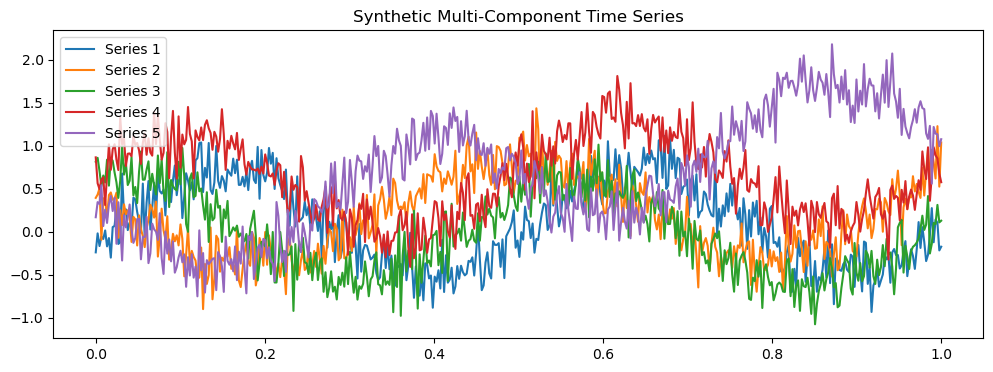

In [4]:
x, y = next(iter(loader))

plt.figure(figsize=(12, 4))
for i in range(y.shape[0]):
    plt.plot(x[0], y[i], label=f"Series {i+1}")
plt.title("Synthetic Multi-Component Time Series")
plt.legend()
plt.show()


In [5]:
def long_term_trend_kernel():
    return gpytorch.kernels.RBFKernel()

def short_term_kernel():
    return gpytorch.kernels.MaternKernel(nu=1.5)

def periodic_kernel():
    return gpytorch.kernels.PeriodicKernel()

def noise_kernel():
    # Simulates latent white noise via tiny lengthscale RBF
    k = gpytorch.kernels.RBFKernel()
    k.lengthscale = 1e-2
    return k


In [6]:
class NamedKernelBuilder:
    def __init__(self):
        self.components = {}  # {name: kernel}

    def add(self, name, kernel):
        self.components[name] = kernel
        return self  # for chaining

    def add_product(self, name, k1, k2):
        self.components[name] = k1 * k2
        return self

    def build(self):
        composite = None
        for k in self.components.values():
            composite = k if composite is None else composite + k
        return composite


In [7]:
def build_kernel_config(long=True, short=True, seasonal=True, noise=True):
    builder = NamedKernelBuilder()

    if long:
        builder.add("long_term", long_term_trend_kernel())

    if short:
        builder.add("short_term", short_term_kernel())

    if seasonal:
        # Periodic * RBF for smooth seasonality
        k_seasonal = periodic_kernel() * kernels.RBFKernel()
        builder.add("seasonality", k_seasonal)

    if noise:
        builder.add("noise", noise_kernel())

    return builder


In [8]:
class BatchedGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, kernel_builder):
        num_tasks, num_inducing, _ = inducing_points.shape
        self.num_tasks = num_tasks

        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=torch.Size([num_tasks])
        )

        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points=inducing_points,
            variational_distribution=variational_distribution,
            learn_inducing_locations=True
        )

        super().__init__(variational_strategy)

        self.mean_module = gpytorch.means.ZeroMean()

        # Store named kernels
        self.named_kernels = kernel_builder.components

        # Build composite kernel and wrap it
        composite_kernel = kernel_builder.build()
        self.covar_module = gpytorch.kernels.ScaleKernel(composite_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [9]:
def select_signal_aware_inducing_points(
    x: torch.Tensor,
    y: torch.Tensor,
    num_inducing: int = 64,
    threshold: float = 0.05,
    bias_ratio: float = 0.5
):
    if y.ndim == 2:
        y = y.squeeze(-1)
    
    signal_mask = y.abs() > threshold
    signal_x = x[signal_mask]
    background_x = x[~signal_mask]

    num_signal = int(bias_ratio * num_inducing)
    num_background = num_inducing - num_signal

    inducing_signal = []
    inducing_background = []

    if len(signal_x) >= num_signal:
        inducing_signal = signal_x[torch.randperm(len(signal_x))[:num_signal]]
    else:
        needed = num_signal - len(signal_x)
        extra = x[torch.randperm(x.shape[0])[:needed]]
        inducing_signal = torch.cat([signal_x, extra], dim=0)

    if len(background_x) >= num_background:
        inducing_background = background_x[torch.randperm(len(background_x))[:num_background]]
    else:
        needed = num_background - len(background_x)
        extra = x[torch.randperm(x.shape[0])[:needed]]
        inducing_background = torch.cat([background_x, extra], dim=0)

    inducing_points = torch.cat([inducing_signal, inducing_background], dim=0)
    inducing_points = inducing_points[:num_inducing]  # ensure exactly N
    inducing_points = inducing_points.sort(dim=0).values

    return inducing_points.unsqueeze(-1)  # [num_inducing, 1]

num_tasks = 5

# 1. Get a batch of data from the DataLoader
train_xs, train_ys = next(iter(loader))  # train_xs: [5, T], train_ys: [5, T]

# 2. Select signal-aware inducing points for each series
inducing_points_list = []

for i in range(num_tasks):
    inducing_i = select_signal_aware_inducing_points(
        x=train_xs[i].unsqueeze(-1),  # shape [T, 1]
        y=train_ys[i],                # shape [T]
        num_inducing=64,
        threshold=0.05,
        bias_ratio=0.7
    )
    inducing_i = inducing_i.squeeze(-1)  # ✅ Ensure shape [64, 1]
    inducing_points_list.append(inducing_i)

# 3. Stack into final shape: [num_tasks, num_inducing, 1]
inducing_points = torch.stack(inducing_points_list)

In [10]:
kernel_builder = build_kernel_config(long=True, short=True, seasonal=True, noise=True)

model = BatchedGPModel(
    inducing_points=inducing_points,
    kernel_builder=kernel_builder
)

likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([num_tasks]))


In [11]:
def log_named_kernel_params(model, epoch):
    print(f"\n🔧 Kernel parameters at epoch {epoch}:")
    for name, kernel in model.named_kernels.items():
        print(f"  • {name.upper()}:")
        
        if hasattr(kernel, "lengthscale"):
            print("    - lengthscale:", kernel.lengthscale.detach().cpu().numpy())

        if hasattr(kernel, "period_length"):
            print("    - period:", kernel.period_length.detach().cpu().numpy())

        if hasattr(kernel, "outputscale"):
            print("    - outputscale:", kernel.outputscale.detach().cpu().numpy())


In [12]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()}
], lr=0.01)

num_data = train_ys.size(1)  # Number of time points (T)
elbo = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=num_data)

num_epochs = 300
for epoch in range(num_epochs):
    optimizer.zero_grad()

    x_batch = train_xs.unsqueeze(-1)  # [N, T, 1]
    y_batch = train_ys                # [N, T]

    output = model(x_batch)
    loss = -elbo(output, y_batch).sum()

    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)  # optional
    optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")

/home/simon/anaconda3/envs/gpytorch_2025/lib/python3.9/site-packages/torch/autograd/graph.py:823: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 000 | Loss: 15.2466
Epoch 010 | Loss: 8.5192
Epoch 020 | Loss: 6.9296
Epoch 030 | Loss: 6.1112
Epoch 040 | Loss: 5.6444
Epoch 050 | Loss: 5.3098
Epoch 060 | Loss: 5.0278
Epoch 070 | Loss: 4.8260
Epoch 080 | Loss: 4.6562
Epoch 090 | Loss: 4.5090
Epoch 100 | Loss: 4.3782
Epoch 110 | Loss: 4.1596
Epoch 120 | Loss: 3.9119
Epoch 130 | Loss: 3.7030
Epoch 140 | Loss: 3.5548
Epoch 150 | Loss: 3.2993
Epoch 160 | Loss: 3.0485
Epoch 170 | Loss: 2.8350
Epoch 180 | Loss: 2.6275
Epoch 190 | Loss: 2.4376
Epoch 200 | Loss: 2.2010
Epoch 210 | Loss: 1.9678
Epoch 220 | Loss: 1.8475
Epoch 230 | Loss: 1.5489
Epoch 240 | Loss: 1.3345
Epoch 250 | Loss: 1.1293
Epoch 260 | Loss: 0.9409
Epoch 270 | Loss: 0.7628
Epoch 280 | Loss: 0.5931
Epoch 290 | Loss: 0.4370
Epoch 299 | Loss: 0.3062


In [4]:
def build_kernel_config(long=True, short=True, seasonal=True, noise=True):
    k = None

    if long:
        k = long_term_trend_kernel() if k is None else k + long_term_trend_kernel()

    if short:
        k = short_term_kernel() if k is None else k + short_term_kernel()

    if seasonal:
        k_seasonal = periodic_kernel() * kernels.RBFKernel()
        k = k_seasonal if k is None else k + k_seasonal

    if noise:
        k = noise_kernel() if k is None else k + noise_kernel()

    return k


In [5]:
class BatchedGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points: torch.Tensor, kernel_builder):
        """
        Args:
            inducing_points: Tensor of shape [num_tasks, num_inducing, input_dim]
            kernel_builder: Function that returns a base_kernel (not wrapped in ScaleKernel)
        """
        num_tasks, num_inducing, _ = inducing_points.shape
        self.num_tasks = num_tasks

        # Variational distribution per task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=torch.Size([num_tasks])
        )

        # Variational strategy per task
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self,
            inducing_points=inducing_points,
            variational_distribution=variational_distribution,
            learn_inducing_locations=True
        )

        super().__init__(variational_strategy)

        # Mean module (default: zero)
        self.mean_module = gpytorch.means.ZeroMean()

        # Build a shared kernel using your function
        base_kernel = kernel_builder()  # ← Plug in custom kernel logic
        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [8]:
# 4. Create model with these inducing points

model = BatchedGPModel(
    inducing_points=inducing_points,
    kernel_builder=lambda: build_kernel_config(long=True, short=True, seasonal=True, noise=True)
)

likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([num_tasks]))


In [11]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()}
], lr=0.01)

num_data = train_ys.size(1)  # Number of time points (T)
elbo = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=num_data)

num_epochs = 300
for epoch in range(num_epochs):
    optimizer.zero_grad()

    x_batch = train_xs.unsqueeze(-1)  # [N, T, 1]
    y_batch = train_ys                # [N, T]

    output = model(x_batch)
    loss = -elbo(output, y_batch).sum()

    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)  # optional
    optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")


Epoch 000 | Loss: -0.6829
Epoch 010 | Loss: -0.2174
Epoch 020 | Loss: -0.5267
Epoch 030 | Loss: -0.6074
Epoch 040 | Loss: -0.6460
Epoch 050 | Loss: -0.6641
Epoch 060 | Loss: -0.6741
Epoch 070 | Loss: -0.6794
Epoch 080 | Loss: -0.6824
Epoch 090 | Loss: -0.6843
Epoch 100 | Loss: -0.6857
Epoch 110 | Loss: -0.6869
Epoch 120 | Loss: -0.6879
Epoch 130 | Loss: -0.6888
Epoch 140 | Loss: -0.6896
Epoch 150 | Loss: -0.6903
Epoch 160 | Loss: -0.6911
Epoch 170 | Loss: -0.6918
Epoch 180 | Loss: -0.6924
Epoch 190 | Loss: -0.6931
Epoch 200 | Loss: -0.6937
Epoch 210 | Loss: -0.6943
Epoch 220 | Loss: -0.6949
Epoch 230 | Loss: -0.6954
Epoch 240 | Loss: -0.6960
Epoch 250 | Loss: -0.6964
Epoch 260 | Loss: -0.6970
Epoch 270 | Loss: -0.6975
Epoch 280 | Loss: -0.6980
Epoch 290 | Loss: -0.6985
Epoch 299 | Loss: -0.6979
